# Detecting Anomalous Streams in the Language dataset

In [1]:
from __future__ import annotations
import random
import time
from typing import Callable

import numpy as np
import pandas as pd

import Data
from signature_mahalanobis_knn.utils import (
    _replace_inf_with_max,
    compute_auc_given_dists,
    plot_cdf_given_dists,
)

from methods import (
    compute_signature_mahalanbois_knn_scores,
    compute_isolation_forest_scores_based_on_moments,
    compute_isolation_forest_scores_signatures,
    compute_local_outlier_factor_scores_based_on_moments,
    compute_local_outlier_factor_scores_signatures,
)

In [2]:
# ignore warnings from sktime about using iisignature backend
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")

In [3]:
seed = 2023
random.seed(seed)
np.random.seed(seed)

bootstrap_samples = 10000

In [4]:
data = Data.Data(if_sample=False, random_seed=seed)

In [5]:
def z_score_normalization(
    scores_1: np.array, scores_2: np.array
) -> tuple[np.array, np.array]:
    scores_1, scores_2 = _replace_inf_with_max(scores_1, scores_2)
    mean = np.mean(np.concatenate([scores_1, scores_2]))
    std = np.std(np.concatenate([scores_1, scores_2]))
    return (scores_1 - mean) / std, (scores_2 - mean) / std


def compute_mse(scores_1: np.array, scores_2: np.array) -> float:
    scores_1, scores_2 = _replace_inf_with_max(scores_1, scores_2)
    return np.nanmean((scores_1 - scores_2) ** 2)


def compute_mae(scores_1: np.array, scores_2: np.array) -> float:
    scores_1, scores_2 = _replace_inf_with_max(scores_1, scores_2)
    return np.nanmean(np.abs(scores_1 - scores_2))

In [6]:
def language_dataset_experiment(
    data: Data.Data,
    anomaly_detection_method: Callable[[Data.Data], dict[str, np.array | float]],
    anomaly_detection_kwargs: dict | None = None,
    add_depth_to_kwargs: bool = False,
    plot: bool = False,
    plot_kwargs: dict | None = None,
) -> dict[str, np.array | float]:
    t0 = time.time()

    if anomaly_detection_kwargs is None:
        anomaly_detection_kwargs = {}
    if plot_kwargs is None:
        plot_kwargs = {}

    results_language_dataset = {
        "cumsum": [],
        "with_prefix": [],
        "auc": [],
        "se": [],
        "total_fit_time": [],
        "total_compute_score_time": [],
        "mse_between_scores": [],
        "rmse_between_scores": [],
        "mae_between_scores": [],
        "mse_between_norm_scores": [],
        "rmse_between_norm_scores": [],
        "mae_between_norm_scores": [],
    }

    fit_times = []
    compute_times = []

    scores = {"cumsum": [], "scores": [], "normalised_scores": []}

    for cumsum in [False, True]:
        scores["cumsum"].append(cumsum)
        anomaly_scores = {}
        for with_prefix in [False, True]:
            # save hyperparameters for results
            results_language_dataset["cumsum"].append(cumsum)
            results_language_dataset["with_prefix"].append(with_prefix)

            data.load_language_data(cumsum=cumsum, with_prefix=with_prefix)
            print(f"start cumsum: {cumsum}, with_prefix: {with_prefix}")

            if add_depth_to_kwargs:
                anomaly_detection_kwargs["depth"] = 2

            # compute the inlier and outlier scores
            results = anomaly_detection_method(data, **anomaly_detection_kwargs)

            # save fit and compute times
            fit_times.append(results["fit_time"])
            compute_times.append(results["compute_score_time"])

            # compute auc for digit
            auc = compute_auc_given_dists(
                results["scores_inliers"], results["scores_outliers"]
            )

            # plot and compute auc
            auc, se = compute_auc_given_dists(
                results["scores_inliers"],
                results["scores_outliers"],
                bootstrap=True,
                bootstrap_samples=bootstrap_samples,
                random_state=seed,
                plot=plot,
                title=f"Language Dataset (with prefix={with_prefix})",
            )

            # save results
            results_language_dataset["auc"].append(auc)
            results_language_dataset["se"].append(se)
            results_language_dataset["total_fit_time"].append(np.sum(fit_times))
            results_language_dataset["total_compute_score_time"].append(
                np.sum(compute_times)
            )

            # save scores
            anomaly_scores[f"with_prefix={with_prefix}"] = np.concatenate(
                [results["scores_inliers"], results["scores_outliers"]]
            )

            if plot:
                # plot CDF
                plot_cdf_given_dists(
                    results["scores_inliers"],
                    results["scores_outliers"],
                    bins=10000000,
                    **plot_kwargs,
                )

            print(
                f"cumsum: {cumsum}, with prefix: {with_prefix} | auc: {auc}, se: {se}"
            )

        scores["scores"].append(tuple(anomaly_scores))
        normalised_scores = {}
        (
            normalised_scores["with_prefix=True"],
            normalised_scores["with_prefix=False"],
        ) = z_score_normalization(
            anomaly_scores["with_prefix=True"], anomaly_scores["with_prefix=False"]
        )
        scores["normalised_scores"].append(normalised_scores)

        # compute MSE, RMSE, MAE between scores
        mse_between_scores = compute_mse(
            anomaly_scores["with_prefix=True"], anomaly_scores["with_prefix=False"]
        )
        rmse_between_scores = np.sqrt(mse_between_scores)
        mae_between_scores = compute_mae(
            anomaly_scores["with_prefix=True"], anomaly_scores["with_prefix=False"]
        )
        print(
            f"MSE between scores (cumsum={cumsum}) with and without prefix: {mse_between_scores}"
        )
        print(
            f"RMSE between scores (cumsum={cumsum}) with and without prefix: {rmse_between_scores}"
        )
        print(
            f"MAE between scores (cumsum={cumsum}) with and without prefix: {mae_between_scores}"
        )
        # save results (twice because we have two with_prefix values to make the dataframe)
        results_language_dataset["mse_between_scores"] += 2 * [mse_between_scores]
        results_language_dataset["rmse_between_scores"] += 2 * [rmse_between_scores]
        results_language_dataset["mae_between_scores"] += 2 * [mae_between_scores]

        # compute MSE, RMSE, MAE between the normalised scores
        mse_between_scores_with_norm = compute_mse(
            normalised_scores["with_prefix=True"],
            normalised_scores["with_prefix=False"],
        )
        rmse_between_scores_with_norm = np.sqrt(mse_between_scores_with_norm)
        mae_between_scores_with_norm = compute_mae(
            normalised_scores["with_prefix=True"],
            normalised_scores["with_prefix=False"],
        )
        print(
            f"MSE (normalised) between scores (cumsum={cumsum}) with and without prefix: {mse_between_scores_with_norm}"
        )
        print(
            f"RMSE (normalised) between scores (cumsum={cumsum}) with and without prefix: {rmse_between_scores_with_norm}"
        )
        print(
            f"MAE (normalised) between scores (cumsum={cumsum}) with and without prefix: {mae_between_scores_with_norm}"
        )
        # save results (twice because we have two with_prefix values to make the dataframe)
        results_language_dataset["mse_between_norm_scores"] += 2 * [mse_between_scores]
        results_language_dataset["rmse_between_norm_scores"] += 2 * [
            rmse_between_scores
        ]
        results_language_dataset["mae_between_norm_scores"] += 2 * [mae_between_scores]

    total_time = time.time() - t0
    print(f"Total experiment time: {total_time} seconds | {total_time / 60} minutes")

    return results_language_dataset, scores

## Signature Mahalanobis KNN

In [7]:
n_neighbours = 100

100%|██████████| 20000/20000 [00:00<00:00, 238345.23it/s]


start cumsum: False, with_prefix: False
fit_time: 11909.900458812714
compute_score_time: 131.26868200302124


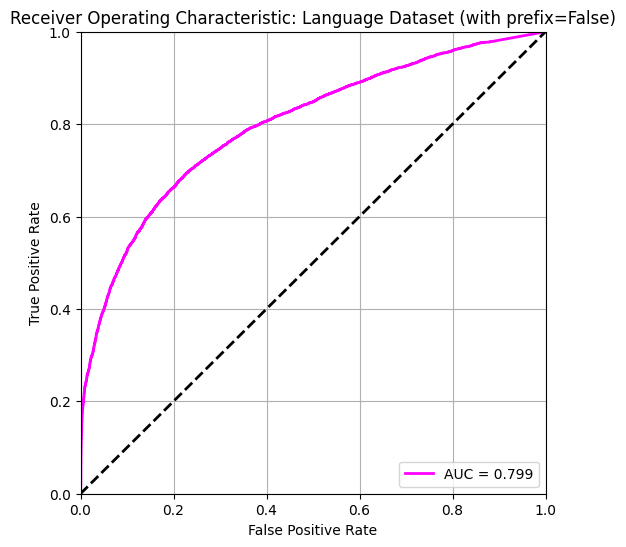

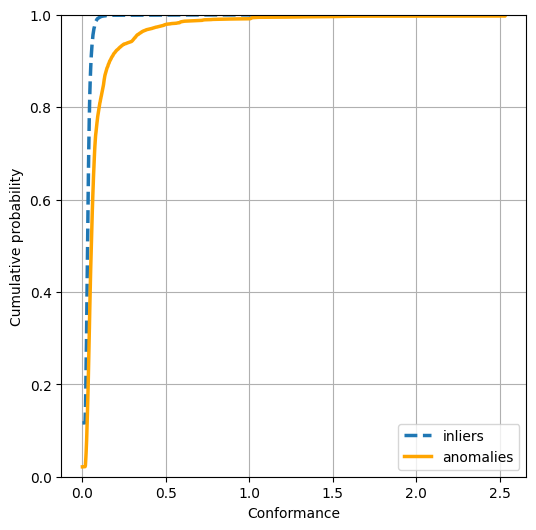

cumsum: False, with prefix: False | auc: 0.798655525, se: 0.0030846640070882475


100%|██████████| 20000/20000 [00:00<00:00, 101822.77it/s]


start cumsum: False, with_prefix: True
fit_time: 11778.503013849258
compute_score_time: 139.26858377456665


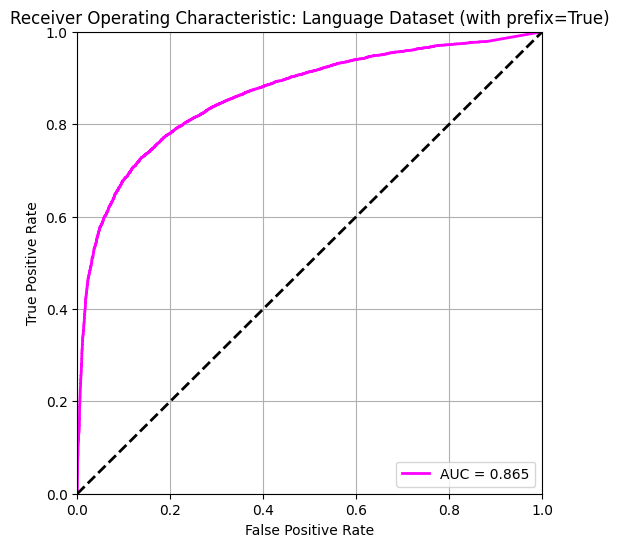

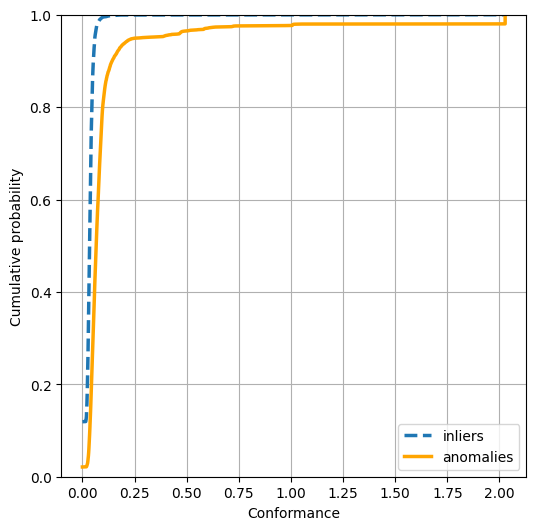

cumsum: False, with prefix: True | auc: 0.8645835500000001, se: 0.0025788060394353837
MSE between scores (cumsum=False) with and without prefix: 0.04824604383356553
RMSE between scores (cumsum=False) with and without prefix: 0.21964982092768828
MAE between scores (cumsum=False) with and without prefix: 0.037033117556071235
MSE (normalised) between scores (cumsum=False) with and without prefix: 1.1171786487600954
RMSE (normalised) between scores (cumsum=False) with and without prefix: 1.0569667207438915
MAE (normalised) between scores (cumsum=False) with and without prefix: 0.17820534820763628


100%|██████████| 20000/20000 [00:00<00:00, 157090.63it/s]


start cumsum: True, with_prefix: False
fit_time: 12482.772598981857
compute_score_time: 95.868243932724


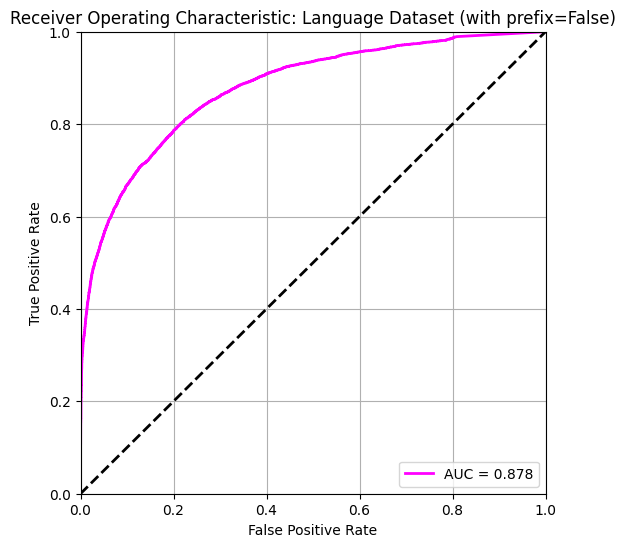

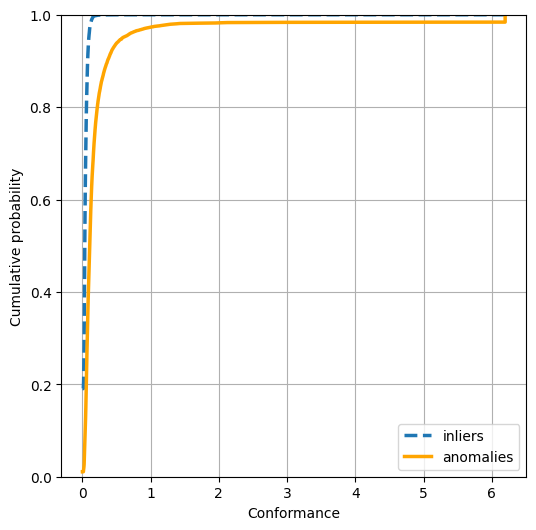

cumsum: True, with prefix: False | auc: 0.8776404200000001, se: 0.0023891142116481837


100%|██████████| 20000/20000 [00:00<00:00, 73235.38it/s]


start cumsum: True, with_prefix: True


In [8]:
(
    results_language_dataset_signature_mahalanobis_knn,
    smk_scores,
) = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_signature_mahalanbois_knn_scores,
    anomaly_detection_kwargs={
        "backend": "iisignature",
        "knn_library": "sklearn",
        "n_neighbours": n_neighbours,
        "random_state": seed,
    },
    add_depth_to_kwargs=True,
    plot=True,
    plot_kwargs=None,
)

In [ ]:
pd.DataFrame(results_language_dataset_signature_mahalanobis_knn)

In [ ]:
pd.DataFrame(results_language_dataset_signature_mahalanobis_knn).to_csv(
    "results/language_dataset_signature_mahalanobis_knn.csv"
)

## Baseline: Isolation Forest

### Using moments as features

In [ ]:
(
    results_language_dataset_isolation_forest_moments,
    ifm_scores,
) = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_isolation_forest_scores_based_on_moments,
    anomaly_detection_kwargs={"random_state": seed},
    add_depth_to_kwargs=False,
    plot=False,
    plot_kwargs=None,
)

100%|██████████| 20000/20000 [00:00<00:00, 265167.74it/s]


start cumsum: False, with_prefix: False
fit_time: 0.10591506958007812
compute_score_time: 0.07188820838928223
cumsum: False, with prefix: False | auc: 0.48081160500000003, se: 0.004103368581742017


100%|██████████| 20000/20000 [00:00<00:00, 120845.11it/s]


start cumsum: False, with_prefix: True
fit_time: 0.10387825965881348
compute_score_time: 0.06962418556213379
cumsum: False, with prefix: True | auc: 0.6342248149999999, se: 0.003884960947243883
MSE between scores (cumsum=False) with and without prefix: 0.003436300899818589
RMSE between scores (cumsum=False) with and without prefix: 0.05861997014515266
MAE between scores (cumsum=False) with and without prefix: 0.05052056571413158
MSE (normalised) between scores (cumsum=False) with and without prefix: 2.5530407537133257
RMSE (normalised) between scores (cumsum=False) with and without prefix: 1.5978237555229067
MAE (normalised) between scores (cumsum=False) with and without prefix: 1.3770556320757623


100%|██████████| 20000/20000 [00:00<00:00, 173391.43it/s]


start cumsum: True, with_prefix: False
fit_time: 0.1050119400024414
compute_score_time: 0.06078672409057617
cumsum: True, with prefix: False | auc: 0.71275548, se: 0.003627706192352872


100%|██████████| 20000/20000 [00:00<00:00, 79831.06it/s]


start cumsum: True, with_prefix: True
fit_time: 0.10580778121948242
compute_score_time: 0.06490182876586914
cumsum: True, with prefix: True | auc: 0.7391926499999999, se: 0.0034993420253571716
MSE between scores (cumsum=True) with and without prefix: 0.0016967020267764222
RMSE between scores (cumsum=True) with and without prefix: 0.041191043040646864
MAE between scores (cumsum=True) with and without prefix: 0.0340457041759254
MSE (normalised) between scores (cumsum=True) with and without prefix: 0.8109855708847232
RMSE (normalised) between scores (cumsum=True) with and without prefix: 0.9005473729264459
MAE (normalised) between scores (cumsum=True) with and without prefix: 0.7443309805193774
Total experiment time: 228.52970695495605 seconds | 3.8088284492492677 minutes


In [ ]:
ifm_scores

{'cumsum': [False, True],
 'scores': [('with_prefix=False', 'with_prefix=True'),
  ('with_prefix=False', 'with_prefix=True')],
 'normalised_scores': [{'with_prefix=True': array([0.13342156, 0.63380013, 0.412591  , ..., 0.32844934, 0.87848177,
          1.73847531]),
   'with_prefix=False': array([-6.46131212e-01, -8.05994725e-01, -7.16190727e-01, ...,
          -7.45588700e-01, -2.74451802e-01, -4.47751595e-04])},
  {'with_prefix=True': array([-0.68918504,  0.02739014, -0.73919443, ..., -0.1830715 ,
           0.26925301,  1.17220621]),
   'with_prefix=False': array([-1.21133284, -0.62809284, -1.2017995 , ..., -0.30176918,
          -0.36429148, -0.78638783])}]}

In [ ]:
pd.DataFrame(results_language_dataset_isolation_forest_moments)

,cumsum,with_prefix,auc,se,total_fit_time,total_compute_score_time,mse_between_scores,rmse_between_scores,mae_between_scores,mse_between_norm_scores,rmse_between_norm_scores,mae_between_norm_scores
0,False,False,0.480812,0.004103,0.105915,0.071888,0.003436,0.058620,0.050521,0.003436,0.058620,0.050521
1,False,True,0.634225,0.003885,0.209793,0.141512,0.003436,0.058620,0.050521,0.003436,0.058620,0.050521
2,True,False,0.712755,0.003628,0.314805,0.202299,0.001697,0.041191,0.034046,0.001697,0.041191,0.034046
3,True,True,0.739193,0.003499,0.420613,0.267201,0.001697,0.041191,0.034046,0.001697,0.041191,0.034046


In [ ]:
pd.DataFrame(results_language_dataset_isolation_forest_moments).to_csv(
    "results/language_dataset_isolation_forest_moments.csv"
)

### Using path signatures as features

In [ ]:
(
    results_language_dataset_isolation_forest_signatures,
    ifs_scores,
) = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_isolation_forest_scores_signatures,
    anomaly_detection_kwargs={"backend": "iisignature", "random_state": seed},
    add_depth_to_kwargs=True,
    plot=False,
    plot_kwargs=None,
)

100%|██████████| 20000/20000 [00:00<00:00, 273485.08it/s]


start cumsum: False, with_prefix: False
fit_time: 0.15921783447265625
compute_score_time: 0.12325215339660645
cumsum: False, with prefix: False | auc: 0.643683775, se: 0.003871060373736696


100%|██████████| 20000/20000 [00:00<00:00, 119682.35it/s]


start cumsum: False, with_prefix: True
fit_time: 0.12366199493408203
compute_score_time: 0.10447096824645996
cumsum: False, with prefix: True | auc: 0.6148406450000001, se: 0.003967800265725457
MSE between scores (cumsum=False) with and without prefix: 0.00014941488322926688
RMSE between scores (cumsum=False) with and without prefix: 0.012223538081474892
MAE between scores (cumsum=False) with and without prefix: 0.009520642218273602


100%|██████████| 20000/20000 [00:00<00:00, 167284.36it/s]


start cumsum: True, with_prefix: False
fit_time: 0.1294260025024414
compute_score_time: 0.0986928939819336
cumsum: True, with prefix: False | auc: 0.722898575, se: 0.00357524646388613


100%|██████████| 20000/20000 [00:00<00:00, 81314.11it/s]


start cumsum: True, with_prefix: True
fit_time: 0.12419819831848145
compute_score_time: 0.11759805679321289
cumsum: True, with prefix: True | auc: 0.7214370449999999, se: 0.0035619707497822413
MSE between scores (cumsum=True) with and without prefix: 0.001229020496122409
RMSE between scores (cumsum=True) with and without prefix: 0.03505738860957001
MAE between scores (cumsum=True) with and without prefix: 0.030745399691977444
Total experiment time: 312.391930103302 seconds | 5.2065321683883665 minutes


In [ ]:
ifs_scores

{'cumsum': [False, True],
 'scores': [{'with_prefix=False': array([0.31781821, 0.32516629, 0.3125105 , ..., 0.32442878, 0.33209533,
          0.33104716]),
   'with_prefix=True': array([0.30953645, 0.3206744 , 0.31051096, ..., 0.33292217, 0.3178306 ,
          0.33336384])},
  {'with_prefix=False': array([0.30489304, 0.32983555, 0.30765616, ..., 0.3281988 , 0.34777753,
          0.34920208]),
   'with_prefix=True': array([0.32966356, 0.37016297, 0.33947163, ..., 0.3879774 , 0.39587632,
          0.39373333])}]}

In [ ]:
pd.DataFrame(results_language_dataset_isolation_forest_signatures)

,cumsum,with_prefix,auc,se,total_fit_time,total_compute_score_time,mse_between_scores,rmse_between_scores,mae_between_scores
0,False,False,0.643684,0.003871,0.159218,0.123252,0.001229,0.035057,0.030745
1,False,True,0.614841,0.003968,0.282880,0.227723,0.001229,0.035057,0.030745
2,True,False,0.722899,0.003575,0.412306,0.326416,0.001229,0.035057,0.030745
3,True,True,0.721437,0.003562,0.536504,0.444014,0.001229,0.035057,0.030745


In [ ]:
pd.DataFrame(results_language_dataset_isolation_forest_signatures).to_csv(
    "results/language_dataset_isolation_forest_signatures.csv"
)

## Baseline: Local Outlier Factor


### Using moments as features

In [ ]:
(
    results_language_dataset_local_outlier_factor_moments,
    lofm_scores,
) = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_local_outlier_factor_scores_based_on_moments,
    anomaly_detection_kwargs={"n_neighbors": n_neighbours},
    add_depth_to_kwargs=False,
    plot=False,
    plot_kwargs=None,
)

100%|██████████| 20000/20000 [00:00<00:00, 271466.32it/s]


start cumsum: False, with_prefix: False
fit_time: 21.977287769317627
compute_score_time: 0.000308990478515625
cumsum: False, with prefix: False | auc: 0.4616964, se: 0.004081516404594727


100%|██████████| 20000/20000 [00:00<00:00, 123815.81it/s]


start cumsum: False, with_prefix: True
fit_time: 23.11544418334961
compute_score_time: 3.695487976074219e-05
cumsum: False, with prefix: True | auc: 0.725796005, se: 0.003553366125326552
MSE between scores (cumsum=False) with and without prefix: 0.010538103328468596
RMSE between scores (cumsum=False) with and without prefix: 0.10265526449465998
MAE between scores (cumsum=False) with and without prefix: 0.06619450836457347


100%|██████████| 20000/20000 [00:00<00:00, 177433.78it/s]


start cumsum: True, with_prefix: False
fit_time: 21.684338092803955
compute_score_time: 0.00022220611572265625
cumsum: True, with prefix: False | auc: 0.769341265, se: 0.0033278189596788873


100%|██████████| 20000/20000 [00:00<00:00, 82397.16it/s]


start cumsum: True, with_prefix: True
fit_time: 23.27287793159485
compute_score_time: 0.00020599365234375
cumsum: True, with prefix: True | auc: 0.759815645, se: 0.0033655994399676707
MSE between scores (cumsum=True) with and without prefix: 0.005326253971207811
RMSE between scores (cumsum=True) with and without prefix: 0.07298118916000075
MAE between scores (cumsum=True) with and without prefix: 0.05606122924400197
Total experiment time: 324.6962020397186 seconds | 5.411603367328643 minutes


In [ ]:
lofm_scores

{'cumsum': [False, True],
 'scores': [{'with_prefix=False': array([1.20986692, 1.06620175, 1.27139665, ..., 1.04026927, 1.12925876,
          1.11252035]),
   'with_prefix=True': array([1.02411849, 1.05819657, 1.02185985, ..., 1.06377009, 1.0853092 ,
          1.07625392])},
  {'with_prefix=False': array([1.01609433, 1.1279413 , 0.97148024, ..., 1.14631549, 1.29521714,
          1.21960133]),
   'with_prefix=True': array([1.05135096, 1.16539665, 0.97552234, ..., 1.13670091, 1.33435137,
          1.34229914])}]}

In [ ]:
pd.DataFrame(results_language_dataset_local_outlier_factor_moments)

,cumsum,with_prefix,auc,se,total_fit_time,total_compute_score_time,mse_between_scores,rmse_between_scores,mae_between_scores
0,False,False,0.461696,0.004082,21.977288,0.000309,0.005326,0.072981,0.056061
1,False,True,0.725796,0.003553,45.092732,0.000346,0.005326,0.072981,0.056061
2,True,False,0.769341,0.003328,66.777070,0.000568,0.005326,0.072981,0.056061
3,True,True,0.759816,0.003366,90.049948,0.000774,0.005326,0.072981,0.056061


In [ ]:
pd.DataFrame(results_language_dataset_local_outlier_factor_moments).to_csv(
    "results/language_dataset_local_outlier_factor_moments.csv"
)

### Using path signatures as features

In [ ]:
(
    results_language_dataset_local_outlier_factor_signatures,
    lofs_scores,
) = language_dataset_experiment(
    data=data,
    anomaly_detection_method=compute_local_outlier_factor_scores_signatures,
    anomaly_detection_kwargs={"backend": "iisignature", "n_neighbors": n_neighbours},
    add_depth_to_kwargs=True,
    plot=False,
    plot_kwargs=None,
)

100%|██████████| 20000/20000 [00:00<00:00, 274292.59it/s]


start cumsum: False, with_prefix: False
fit_time: 42.357036113739014
compute_score_time: 2.9087066650390625e-05
cumsum: False, with prefix: False | auc: 0.740694545, se: 0.0035208531922066005


100%|██████████| 20000/20000 [00:00<00:00, 124513.45it/s]


start cumsum: False, with_prefix: True
fit_time: 39.638593912124634
compute_score_time: 3.600120544433594e-05
cumsum: False, with prefix: True | auc: 0.77737512, se: 0.003251635395765534
MSE between scores (cumsum=False) with and without prefix: 4.90039086672342e+19
RMSE between scores (cumsum=False) with and without prefix: 7000279184.949283
MAE between scores (cumsum=False) with and without prefix: 3394218462.8142953


100%|██████████| 20000/20000 [00:00<00:00, 171146.13it/s]


start cumsum: True, with_prefix: False
fit_time: 40.66683292388916
compute_score_time: 3.0994415283203125e-05
cumsum: True, with prefix: False | auc: 0.7868756699999999, se: 0.003196186581723461


100%|██████████| 20000/20000 [00:00<00:00, 81941.13it/s]


start cumsum: True, with_prefix: True
fit_time: 43.234313011169434
compute_score_time: 3.1948089599609375e-05
cumsum: True, with prefix: True | auc: 0.775206775, se: 0.0032984200609127838
MSE between scores (cumsum=True) with and without prefix: 0.011479458949545137
RMSE between scores (cumsum=True) with and without prefix: 0.10714223700084452
MAE between scores (cumsum=True) with and without prefix: 0.08431158182023502
Total experiment time: 485.0304901599884 seconds | 8.083841502666473 minutes


In [ ]:
lofs_scores

{'cumsum': [False, True],
 'scores': [{'with_prefix=False': array([9.91719486e-01, 1.02928345e+00, 9.84035562e-01, ...,
          1.41230353e+09, 1.11587116e+00, 1.33388800e+10]),
   'with_prefix=True': array([0.97877268, 0.98635321, 0.98657449, ..., 1.17402375, 1.26703633,
          1.3691457 ])},
  {'with_prefix=False': array([1.22339041, 1.21994408, 1.04862531, ..., 1.27383777, 1.32286783,
          1.29187666]),
   'with_prefix=True': array([1.00820954, 1.1756379 , 1.0497486 , ..., 1.18167617, 1.21942807,
          1.23117207])}]}

In [ ]:
pd.DataFrame(results_language_dataset_local_outlier_factor_signatures)

,cumsum,with_prefix,auc,se,total_fit_time,total_compute_score_time,mse_between_scores,rmse_between_scores,mae_between_scores
0,False,False,0.740695,0.003521,42.357036,0.000029,0.011479,0.107142,0.084312
1,False,True,0.777375,0.003252,81.995630,0.000065,0.011479,0.107142,0.084312
2,True,False,0.786876,0.003196,122.662463,0.000096,0.011479,0.107142,0.084312
3,True,True,0.775207,0.003298,165.896776,0.000128,0.011479,0.107142,0.084312


In [ ]:
pd.DataFrame(results_language_dataset_local_outlier_factor_signatures).to_csv(
    "results/language_dataset_local_outlier_factor_signatures.csv"
)